In [1]:
# Copyright (c) Meta Platforms, Inc. and affiliates.

# Semantic Segmentation <a target="_blank" href="https://colab.research.google.com/github/facebookresearch/dinov2/blob/main/notebooks/semantic_segmentation.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import sys

INSTALL = False # Switch this to install dependencies
if INSTALL: # Try installing package with extras
    REPO_URL = "https://github.com/facebookresearch/dinov2"
    !{sys.executable} -m pip install -e {REPO_URL}'[extras]' --extra-index-url https://download.pytorch.org/whl/cu117  --extra-index-url https://pypi.nvidia.com
else:
    REPO_PATH = "." # Specify a local path to the repository (or use installed package instead)
    sys.path.append(REPO_PATH)

## Utilities

In [3]:
import math
import itertools
from functools import partial

import torch
import torch.nn.functional as F
from mmseg.apis import init_segmentor, inference_segmentor

import dinov2.eval.segmentation.models
from dinov2.eval.depth.models import build_depther


class CenterPadding(torch.nn.Module):
    def __init__(self, multiple):
        super().__init__()
        self.multiple = multiple

    def _get_pad(self, size):
        new_size = math.ceil(size / self.multiple) * self.multiple
        pad_size = new_size - size
        pad_size_left = pad_size // 2
        pad_size_right = pad_size - pad_size_left
        return pad_size_left, pad_size_right

    @torch.inference_mode()
    def forward(self, x):
        pads = list(itertools.chain.from_iterable(self._get_pad(m) for m in x.shape[:1:-1]))
        output = F.pad(x, pads)
        return output


def create_segmenter(cfg, backbone_model):
    model = init_segmentor(cfg)
    model.backbone.forward = partial(
        backbone_model.get_intermediate_layers,
        n=cfg.model.backbone.out_indices,
        reshape=True,
    )
    if hasattr(backbone_model, "patch_size"):
        model.backbone.register_forward_pre_hook(lambda _, x: CenterPadding(backbone_model.patch_size)(x[0]))
    model.init_weights()
    return model

def create_depther(cfg, backbone_model, backbone_size, head_type):
    train_cfg = cfg.get("train_cfg")
    test_cfg = cfg.get("test_cfg")
    depther = build_depther(cfg.model, train_cfg=train_cfg, test_cfg=test_cfg)

    depther.backbone.forward = partial(
        backbone_model.get_intermediate_layers,
        n=cfg.model.backbone.out_indices,
        reshape=True,
        return_class_token=cfg.model.backbone.output_cls_token,
        norm=cfg.model.backbone.final_norm,
    )

    if hasattr(backbone_model, "patch_size"):
        depther.backbone.register_forward_pre_hook(lambda _, x: CenterPadding(backbone_model.patch_size)(x[0]))

    return depther

## Load pretrained backbone

In [4]:
BACKBONE_SIZE = "small" # in ("small", "base", "large" or "giant")


backbone_archs = {
    "small": "vits14",
    "base": "vitb14",
    "large": "vitl14",
    "giant": "vitg14",
}
backbone_arch = backbone_archs[BACKBONE_SIZE]
backbone_name = f"dinov2_{backbone_arch}"

backbone_model = torch.hub.load(repo_or_dir="facebookresearch/dinov2", model=backbone_name)
backbone_model.eval()
backbone_model.cuda();

Using cache found in /home/romet/.cache/torch/hub/facebookresearch_dinov2_main
/home/romet/projects/ut/milrem/waypoint_planner/dinov2/layers/swiglu_ffn.py:43: UserWarning: xFormers is available (SwiGLU)
  warnings.warn("xFormers is available (SwiGLU)")
/home/romet/projects/ut/milrem/waypoint_planner/dinov2/layers/attention.py:27: UserWarning: xFormers is available (Attention)
  warnings.warn("xFormers is available (Attention)")
/home/romet/projects/ut/milrem/waypoint_planner/dinov2/layers/block.py:33: UserWarning: xFormers is available (Block)
  warnings.warn("xFormers is available (Block)")


## Load pretrained segmentation head

In [5]:
import urllib

import mmcv
from mmcv.runner import load_checkpoint


def load_config_from_url(url: str) -> str:
    with urllib.request.urlopen(url) as f:
        return f.read().decode()


SEG_HEAD_SCALE_COUNT = 3 # more scales: slower but better results, in (1,2,3,4,5)
SEG_HEAD_DATASET = "voc2012" # in ("ade20k", "voc2012")
SEG_HEAD_TYPE = "ms" # in ("ms, "linear")


DINOV2_BASE_URL = "https://dl.fbaipublicfiles.com/dinov2"
head_config_url = f"{DINOV2_BASE_URL}/{backbone_name}/{backbone_name}_{SEG_HEAD_DATASET}_{SEG_HEAD_TYPE}_config.py"
head_checkpoint_url = f"{DINOV2_BASE_URL}/{backbone_name}/{backbone_name}_{SEG_HEAD_DATASET}_{SEG_HEAD_TYPE}_head.pth"

cfg_str = load_config_from_url(head_config_url)
cfg = mmcv.Config.fromstring(cfg_str, file_format=".py")
if SEG_HEAD_TYPE == "ms":
    cfg.data.test.pipeline[1]["img_ratios"] = cfg.data.test.pipeline[1]["img_ratios"][:SEG_HEAD_SCALE_COUNT]
    print("scales:", cfg.data.test.pipeline[1]["img_ratios"])

seg_model = create_segmenter(cfg, backbone_model=backbone_model)
load_checkpoint(seg_model, head_checkpoint_url, map_location="cpu")
seg_model.cuda()
seg_model.eval();

/home/romet/miniconda3/envs/dinov2-extras/lib/python3.9/site-packages/mmseg/models/losses/cross_entropy_loss.py:235: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(
2023-09-13 17:09:33,699 - mmcv - INFO - initialize BNHead with init_cfg {'type': 'Normal', 'std': 0.01, 'override': {'name': 'conv_seg'}}
2023-09-13 17:09:33,700 - mmcv - INFO - 
decode_head.conv_seg.weight - torch.Size([21, 1536, 1, 1]): 
NormalInit: mean=0, std=0.01, bias=0 
 
2023-09-13 17:09:33,700 - mmcv - INFO - 
decode_head.conv_seg.bias - torch.Size([21]): 
NormalInit: mean=0, std=0.01, bias=0 
 
2023-09-13 17:09:33,701 - mmcv - INFO - 
decode_head.bn.weight - torch.Size([1536]): 
The value is the same before and after calling `init_weights` of EncoderDecoder  
 
2023-09-13 17:09:33,701 - mmcv - INFO - 
decode_head.bn.bias - torc

scales: [1.0, 1.32, 1.73]
load checkpoint from http path: https://dl.fbaipublicfiles.com/dinov2/dinov2_vits14/dinov2_vits14_voc2012_ms_head.pth


In [26]:
f"{DINOV2_BASE_URL}/{backbone_name}/{backbone_name}_{DEPTH_HEAD_DATASET}_{DEPTH_HEAD_TYPE}_config.py"

'https://dl.fbaipublicfiles.com/dinov2/dinov2_vits14/dinov2_vits14_kitti_dpt_config.py'

## Load pretrained depth head

In [6]:
import urllib

import mmcv
from mmcv.runner import load_checkpoint


def load_config_from_url(url: str) -> str:
    with urllib.request.urlopen(url) as f:
        return f.read().decode()


DEPTH_HEAD_DATASET = "kitti" # in ("nyu", "kitti")
DEPTH_HEAD_TYPE = "dpt" # in ("linear", "linear4", "dpt")


DINOV2_BASE_URL = "https://dl.fbaipublicfiles.com/dinov2"
head_config_url = f"{DINOV2_BASE_URL}/{backbone_name}/{backbone_name}_{DEPTH_HEAD_DATASET}_{DEPTH_HEAD_TYPE}_config.py"
head_checkpoint_url = f"{DINOV2_BASE_URL}/{backbone_name}/{backbone_name}_{DEPTH_HEAD_DATASET}_{DEPTH_HEAD_TYPE}_head.pth"

cfg_str = load_config_from_url(head_config_url)
cfg = mmcv.Config.fromstring(cfg_str, file_format=".py")

depth_model = create_depther(
    cfg,
    backbone_model=backbone_model,
    backbone_size=BACKBONE_SIZE,
    head_type=DEPTH_HEAD_TYPE,
)

load_checkpoint(depth_model, head_checkpoint_url, map_location="cpu")
depth_model.eval()
depth_model.cuda();

load checkpoint from http path: https://dl.fbaipublicfiles.com/dinov2/dinov2_vits14/dinov2_vits14_kitti_dpt_head.pth


Downloading: "https://dl.fbaipublicfiles.com/dinov2/dinov2_vits14/dinov2_vits14_kitti_dpt_head.pth" to /home/romet/.cache/torch/hub/checkpoints/dinov2_vits14_kitti_dpt_head.pth
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160M/160M [00:15<00:00, 10.9MB/s]


## Load sample image

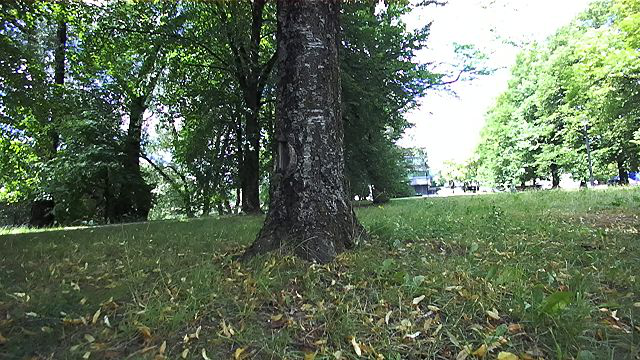

In [7]:
import urllib

from PIL import Image


def load_image_from_url(url: str) -> Image:
    with urllib.request.urlopen(url) as f:
        return Image.open(f).convert("RGB")

def load_image_from_file(f: str) -> Image:
    return Image.open(f).convert("RGB")

    
#EXAMPLE_IMAGE_URL = "https://dl.fbaipublicfiles.com/dinov2/images/example.jpg"
#image = load_image_from_url(EXAMPLE_IMAGE_URL)

#EXAMPLE_IMAGE_URL = "/home/romet/projects/ut/milrem/drive-any-robot/datasets/milrem/2023-04-12-16-02-01_0_39037_train/2000.jpg"
EXAMPLE_IMAGE_URL = "/home/romet/projects/ut/milrem/test-data/2023-07-28-14-08-06/images/img8840.jpg"
image = load_image_from_file(EXAMPLE_IMAGE_URL)

display(image)

## Load pretrained segmentation model (Mask2Former)

In [8]:
import dinov2.eval.segmentation_m2f.models.segmentors

CONFIG_URL = f"{DINOV2_BASE_URL}/dinov2_vitg14/dinov2_vitg14_ade20k_m2f_config.py"
CHECKPOINT_URL = f"{DINOV2_BASE_URL}/dinov2_vitg14/dinov2_vitg14_ade20k_m2f.pth"

cfg_str = load_config_from_url(CONFIG_URL)
cfg = mmcv.Config.fromstring(cfg_str, file_format=".py")

seg_model = init_segmentor(cfg)
load_checkpoint(seg_model, CHECKPOINT_URL, map_location="cpu")
seg_model.cuda()
seg_model.eval();

/home/romet/projects/ut/milrem/waypoint_planner/dinov2/eval/segmentation_m2f/models/losses/cross_entropy_loss.py:222: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(
/home/romet/miniconda3/envs/dinov2-extras/lib/python3.9/site-packages/mmcv/ops/multi_scale_deform_attn.py:209: UserWarning: You'd better set embed_dims in MultiScaleDeformAttention to make the dimension of each attention head a power of 2 which is more efficient in our CUDA implementation.
  warnings.warn(


load checkpoint from http path: https://dl.fbaipublicfiles.com/dinov2/dinov2_vitg14/dinov2_vitg14_ade20k_m2f.pth


## Semantic segmentation on sample image

/home/romet/miniconda3/envs/dinov2-extras/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1678402374358/work/aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


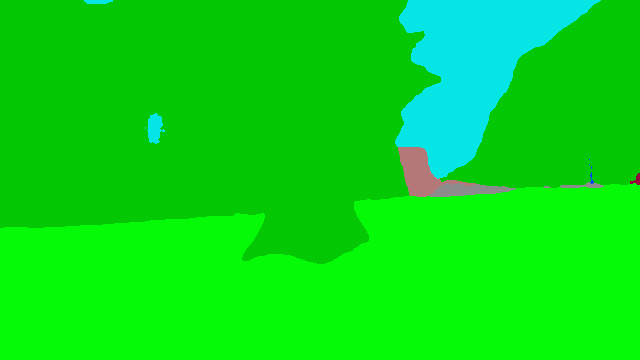

In [9]:
import numpy as np
import dinov2.eval.segmentation.utils.colormaps as colormaps

DATASET_COLORMAPS = {
    "ade20k": colormaps.ADE20K_COLORMAP,
    "voc2012": colormaps.VOC2012_COLORMAP,
}


def render_segmentation(segmentation_logits, dataset):
    colormap = DATASET_COLORMAPS[dataset]
    colormap_array = np.array(colormap, dtype=np.uint8)
    segmentation_values = colormap_array[segmentation_logits + 1]
    return Image.fromarray(segmentation_values)

array = np.array(image)[:, :, ::-1] # BGR
segmentation_logits = inference_segmentor(seg_model, array)[0]
segmented_image = render_segmentation(segmentation_logits, "ade20k")
display(segmented_image)

## Estimate depth on sample image

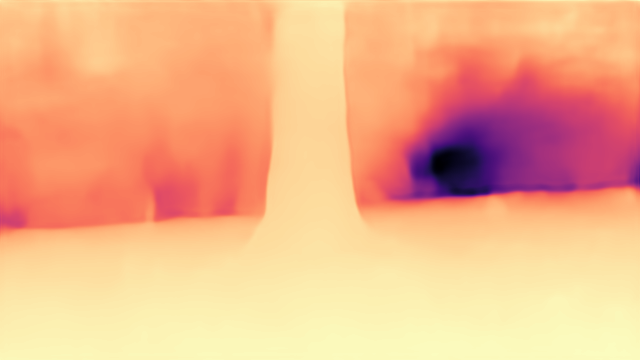

In [10]:
import matplotlib
from torchvision import transforms


def make_depth_transform() -> transforms.Compose:
    return transforms.Compose([
        transforms.ToTensor(),
        lambda x: 255.0 * x[:3], # Discard alpha component and scale by 255
        transforms.Normalize(
            mean=(123.675, 116.28, 103.53),
            std=(58.395, 57.12, 57.375),
        ),
    ])


def render_depth(values, colormap_name="magma_r") -> Image:
    min_value, max_value = values.min(), values.max()
    normalized_values = (values - min_value) / (max_value - min_value)

    colormap = matplotlib.colormaps[colormap_name]
    colors = colormap(normalized_values, bytes=True) # ((1)xhxwx4)
    colors = colors[:, :, :3] # Discard alpha component
    return Image.fromarray(colors)


transform = make_depth_transform()

scale_factor = 1
rescaled_image = image.resize((scale_factor * image.width, scale_factor * image.height))
transformed_image = transform(rescaled_image)
batch = transformed_image.unsqueeze(0).cuda() # Make a batch of one image

with torch.inference_mode():
    result = depth_model.whole_inference(batch, img_meta=None, rescale=True)

depth_image = render_depth(result.squeeze().cpu())
display(depth_image)

In [11]:
from data.dataset import MilremDataset
import yaml
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms


In [12]:
def load_dataset(dataset_path, data_range, config):
    transform = [
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
    image_transform = transforms.Compose(transform)
    aspect_ratio = config["image_size"][0] / config["image_size"][1]
    return MilremDataset(dataset_path, image_transform, config['image_size'], aspect_ratio, data_range, **config)

with open('config/vae-no-context.yaml', 'r') as file:
        config = yaml.safe_load(file)
SCALE = 4
config["image_size"] = [SCALE*98, SCALE*70]


data_root = '/home/romet/projects/ut/milrem/test-data'
dataset_path = Path(data_root) / '2023-07-28-14-08-06'
dataset = load_dataset(dataset_path, None, config)

torch.Size([3, 280, 392])


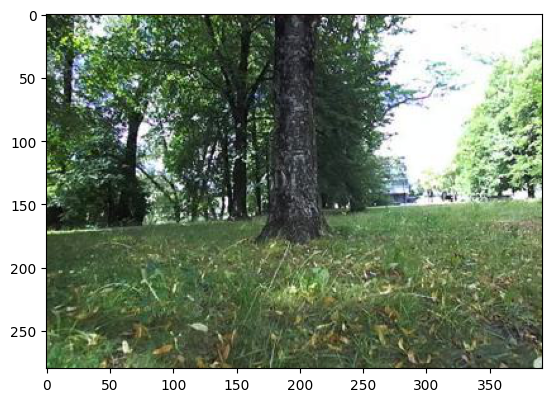

In [13]:
observations, waypoint_img, (action_label, distance_label), metadata = dataset[1280]
observations.shape

image_normalize = transforms.Normalize(mean=np.array([0.485, 0.456, 0.406]), std=np.array([0.229, 0.224, 0.225]))
image_unnormalize = transforms.Normalize((-image_normalize.mean / image_normalize.std).tolist(), (1.0 / image_normalize.std).tolist())

print(observations.shape)
plt.imshow(image_unnormalize(observations).permute(1, 2, 0));

In [14]:
def concat_h(im1, im2):
    dst = Image.new('RGB', (im1.width + im2.width, im1.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (im1.width, 0))
    return dst

def concat_v(im1, im2):
    dst = Image.new('RGB', (im1.width, im1.height + im2.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (0, im1.height))
    return dst

In [18]:
from sklearn.decomposition import PCA
import sklearn
from sklearn.preprocessing import MinMaxScaler


def viz_features(input_obs):
    with torch.no_grad():
        #features = backbone_model(input_obs)
        features_dict = backbone_model.forward_features(input_obs)
        features = features_dict['x_prenorm'][:, 1:]
           
    patch_h = int(SCALE*5)
    patch_w = int(SCALE*7)
    features = features.reshape(1 * patch_h * patch_w, -1).detach().cpu().numpy()
    
    pca = PCA(n_components=3)
    scaler = MinMaxScaler(clip=True)
    
    pca.fit(features)
    pca_features = pca.transform(features)
    scaler.fit(pca_features)
    pca_feature = scaler.transform(pca_features)
    
    # is_foreground_larger_than_threshold = False
    # background_threshold = 0.1
    
    # #Foreground/Background
    # if is_foreground_larger_than_threshold:
    #     pca_features_bg = pca_features[:, 0] < background_threshold
    # else:
    #     pca_features_bg = pca_features[:, 0] > background_threshold
    
    # pca_features_fg = ~pca_features_bg
    # #pca_features_fg = True
    # #print(pca_features_bg)
    
    # # PCA with only foreground
    # pca.fit(features[pca_features_fg])
    # pca_features_rem = pca.transform(features[pca_features_fg])
    
    # # Min Max Normalization
    # scaler.fit(pca_features_rem)
    # pca_features_rem = scaler.transform(pca_features_rem)
    
    # pca_features_rgb = np.zeros((patch_h * patch_w, 3))
    # pca_features_rgb[pca_features_bg] = 0
    # pca_features_rgb[pca_features_fg] = pca_features_rem
    #pca_features_rgb = pca_features_rgb.reshape(patch_h, patch_w, 3)
    pca_features_rgb = pca_feature.reshape(patch_h, patch_w, 3)
    return pca_features_rgb

In [20]:
with torch.inference_mode():
    result = depth_model.whole_inference(observations.cuda().unsqueeze(dim=0), img_meta=None, rescale=True)

depth_image = render_depth(result.squeeze().cpu())

In [22]:
observations.shape

torch.Size([3, 280, 392])

In [24]:
depth_model.whole_inference

<bound method DepthEncoderDecoder.whole_inference of DepthEncoderDecoder(
  (backbone): DinoVisionTransformer()
  (decode_head): DPTHead(
    align_corners=False
    (loss_decode): ModuleList(
      (0): SigLoss()
      (1): GradientLoss()
    )
    (conv_depth): HeadDepth(
      (head): Sequential(
        (0): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): Interpolate()
        (2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU()
        (4): Conv2d(32, 1, kernel_size=(1, 1), stride=(1, 1))
      )
    )
    (relu): ReLU()
    (sigmoid): Sigmoid()
    (reassemble_blocks): ReassembleBlocks(
      (projects): ModuleList(
        (0): ConvModule(
          (conv): Conv2d(384, 48, kernel_size=(1, 1), stride=(1, 1))
        )
        (1): ConvModule(
          (conv): Conv2d(384, 96, kernel_size=(1, 1), stride=(1, 1))
        )
        (2): ConvModule(
          (conv): Conv2d(384, 192, kernel_size=(1, 1), stride=(1,

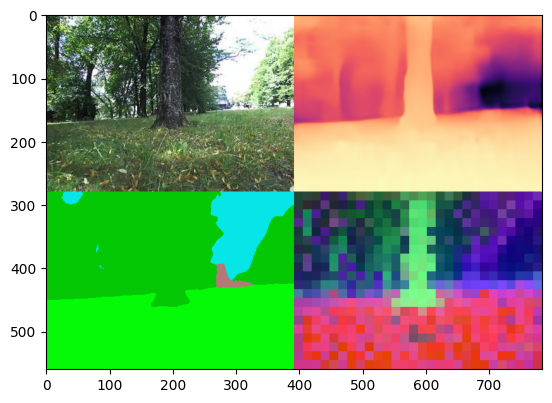

In [16]:
import PIL

#array = np.array(image)[:, :, ::-1] # BGR
array = image_unnormalize(observations).permute(1, 2, 0).detach().cpu().numpy()
input_image = Image.fromarray(np.array(array*255, dtype=np.uint8))

#array = np.array(image)[:, :, ::-1] # BGR
segmentation_logits = inference_segmentor(seg_model, np.array(array*255, dtype=np.uint8))[0]
segmented_image = render_segmentation(segmentation_logits, "ade20k")

with torch.inference_mode():
    result = depth_model.whole_inference(observations.cuda().unsqueeze(dim=0), img_meta=None, rescale=True)

depth_image = render_depth(result.squeeze().cpu())

input_obs = observations.unsqueeze(dim=0).to('cuda')
pca_features = viz_features(input_obs)
pca_features_img = Image.fromarray(np.array(pca_features*255, dtype=np.uint8)).resize(segmented_image.size, resample=PIL.Image.NEAREST)

result1 = concat_h(input_image, depth_image)
result2 = concat_h(segmented_image, pca_features_img)
result = concat_v(result1, result2)
plt.imshow(result)

In [17]:
from tqdm.auto import trange, tqdm
import cv2
import shutil
import os
from moviepy.video.io.ImageSequenceClip import ImageSequenceClip

def convert_frames_to_video(frames_folder, output_video_path, fps=15):
    output_folder = Path(os.path.split(output_video_path)[:-1][0])
    output_folder.mkdir(parents=True, exist_ok=True)

    p = Path(frames_folder).glob('**/*.jpg')
    image_list = sorted([str(x) for x in p if x.is_file()])

    print("Creating video {}, FPS={}".format(frames_folder, fps))
    clip = ImageSequenceClip(image_list, fps=fps)
    clip.write_videofile(str(output_video_path))

#dataloader = torch.utils.data.DataLoader(dataset, num_workers=1, batch_size=400, shuffle=False, drop_last=True)

temp_frames_folder = Path("./segment-temp")
shutil.rmtree(temp_frames_folder, ignore_errors=True)
temp_frames_folder.mkdir()


for frame_index in trange(len(dataset)):
    #if frame_index > 30:
    #   break
        
    observations, waypoint_img, (action_label, distance_label), metadata = dataset[frame_index]
    array = image_unnormalize(observations).permute(1, 2, 0).detach().cpu().numpy()
    input_image = Image.fromarray(np.array(array*255, dtype=np.uint8))
    
    #array = np.array(image)[:, :, ::-1] # BGR
    segmentation_logits = inference_segmentor(seg_model, np.array(array*255, dtype=np.uint8))[0]
    segmented_image = render_segmentation(segmentation_logits, "ade20k")
    
    with torch.inference_mode():
        result = depth_model.whole_inference(observations.cuda().unsqueeze(dim=0), img_meta=None, rescale=True)
    
    depth_image = render_depth(result.squeeze().cpu())
    
    input_obs = observations.unsqueeze(dim=0).to('cuda')
    pca_features = viz_features(input_obs)
    pca_features_img = Image.fromarray(np.array(pca_features*255, dtype=np.uint8)).resize(segmented_image.size, resample=PIL.Image.NEAREST)
    
    result1 = concat_h(input_image, depth_image)
    result2 = concat_h(segmented_image, pca_features_img)
    result = concat_v(result1, result2)
   
    result.save(f"{temp_frames_folder}/{frame_index + 1:05}.jpg")
    
convert_frames_to_video(temp_frames_folder, "dino3.mp4")
    
#shutil.rmtree(temp_frames_folder, ignore_errors=True)

  0%|          | 0/2358 [00:00<?, ?it/s]

Creating video segment-temp, FPS=15
Moviepy - Building video dino3.mp4.
Moviepy - Writing video dino3.mp4



Moviepy - Done !
Moviepy - video ready dino3.mp4
